In [72]:
import sklearn

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

# Get the Data

In [73]:
n_samples = 1000

X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state=42
)

len(X), len(y)

(1000, 1000)

In [74]:
circles_df = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})

circles_df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


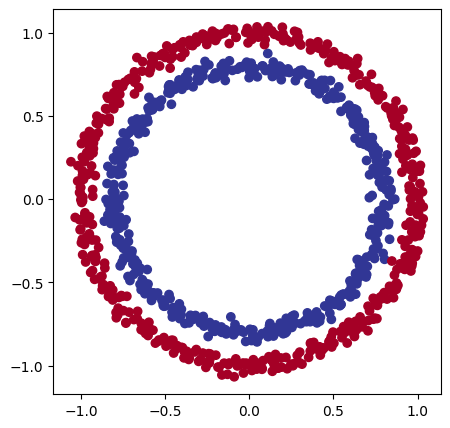

In [75]:
plt.figure(figsize=(5, 5))

plt.scatter(
    circles_df["X1"],
    circles_df["X2"],
    c=y,
    cmap=plt.cm.RdYlBu
)

plt.show()

In [76]:
import torch

torch.__version__

'2.5.0+cu124'

In [77]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [78]:
X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [79]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test)

(800, 200)

# Build the Model

In [82]:
import torch

from torch import nn

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [84]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super(CircleModelV0, self).__init__()
        self.layer_1 = nn.Linear(
            in_features=2,
            out_features=5
        )
        self.layer_2 = nn.Linear(
            in_features=5,
            out_features=1
        )
        
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [85]:
model_0 = CircleModelV0().to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [86]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [87]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [88]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super(CircleModelV1, self).__init__()
        self.layer_1 = nn.Linear(
            in_features=2,
            out_features=5
        )
        self.layer_2 = nn.Linear(
            in_features=5,
            out_features=1
        )

        self.two_linear_layers = nn.Sequential(
            self.layer_1,
            self.layer_2
        )
        
    def forward(self, x):
        return self.two_linear_layers(x)

In [89]:
model_1 = CircleModelV1().to(device)

model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [90]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.1213], device='cuda:0')),
             ('two_linear_layers.0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('two_linear_layers.0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('two_linear_laye

In [91]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [92]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100

    return acc

# Train the Model

In [93]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [94]:
epochs = 100

X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.no_grad():
        y_logits = model_0(X_test).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        test_loss = loss_fn(y_logits, y_test)
        test_acc = accuracy_fn(y_test, y_pred)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | loss: {loss:.2f} | acc: {acc:.2f} | test_loss: {test_loss:.2f} | test_acc: {test_acc:.2f}")

Epoch: 0 | loss: 0.70 | acc: 50.00 | test_loss: 0.70 | test_acc: 50.00
Epoch: 10 | loss: 0.69 | acc: 50.00 | test_loss: 0.69 | test_acc: 50.00
Epoch: 20 | loss: 0.69 | acc: 48.25 | test_loss: 0.70 | test_acc: 46.50
Epoch: 30 | loss: 0.69 | acc: 51.88 | test_loss: 0.69 | test_acc: 47.00
Epoch: 40 | loss: 0.69 | acc: 51.25 | test_loss: 0.69 | test_acc: 46.00
Epoch: 50 | loss: 0.69 | acc: 51.00 | test_loss: 0.69 | test_acc: 46.00
Epoch: 60 | loss: 0.69 | acc: 51.12 | test_loss: 0.69 | test_acc: 46.00
Epoch: 70 | loss: 0.69 | acc: 51.00 | test_loss: 0.69 | test_acc: 45.00
Epoch: 80 | loss: 0.69 | acc: 51.50 | test_loss: 0.69 | test_acc: 45.50
Epoch: 90 | loss: 0.69 | acc: 51.12 | test_loss: 0.69 | test_acc: 45.50
